## Using RNN, LSTM and GRU to classify sentiment on IMDB data

#### 1. Load and preprocess IMDB dataset and sample plotting

In [45]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import matplotlib.pyplot as plt
import numpy as np

# Load top 10,000 most common words
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

print(f"Train sequences: {len(x_train)}, Test sequences: {len(x_test)}")
print(f"Example review (encoded): {x_train[0][:10]}")
print(f"Sentiment: {y_train[0]}")


Train sequences: 25000, Test sequences: 25000
Example review (encoded): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Sentiment: 1


In [46]:
x_train[:5]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [47]:
# Load word index and prepare reverse lookup
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"

# Decode function
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
print(decode_review(x_train[5]))

<START> begins better than it ends funny that the russian submarine crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br


In [49]:
# Pick a sample
sample_id = 100
print(" Sample Review (encoded):", x_train[sample_id][:10], "...")  # Truncated view
print("\n Decoded Review Text:\n")
print(decode_review(x_train[sample_id]))

# Sentiment label
print("\n Sentiment:", "Positive" if y_train[sample_id] == 1 else "Negative")

 Sample Review (encoded): [1, 13, 244, 6, 87, 337, 7, 628, 2219, 5] ...

 Decoded Review Text:

<START> i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of <UNK> drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was <UNK> on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep <UNK> the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the <UNK> box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10

 Sentiment: Negative


#### 2. Pad Sequences to Same Length

In [50]:
maxlen = 200  # Cut off reviews after 200 words
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print(f"Padded review shape: {x_train.shape}")

Padded review shape: (25000, 200)


#### 3. Visualize Word Distribution and a Sample Review

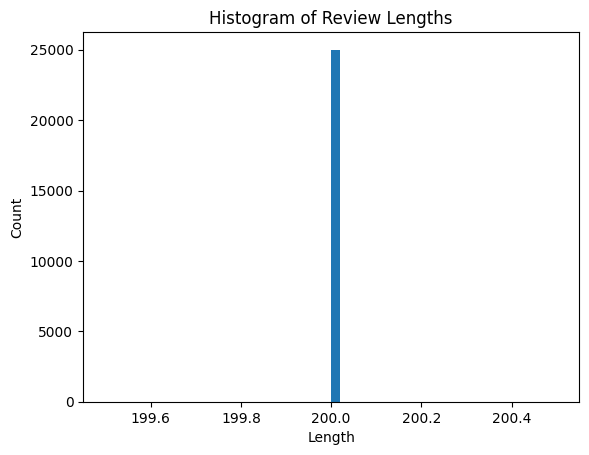


Decoded review:

and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life 

In [51]:
# Histogram of review lengths before padding
review_lengths = [len(seq) for seq in x_train]
plt.hist(review_lengths, bins=50)
plt.title("Histogram of Review Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

# Decode a sample review
word_index = imdb.get_word_index()
reverse_word_index = {value+3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

print("\nDecoded review:\n")
print(decode_review(x_train[0]))


#### 4. Build a Simple Vanilla RNN

In [52]:
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=maxlen),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Dropout(0.4),
    SimpleRNN(32),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer=Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 5. Train the model

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.5089 - loss: 0.7214 - val_accuracy: 0.5266 - val_loss: 0.6910
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5441 - loss: 0.6922 - val_accuracy: 0.7094 - val_loss: 0.5916
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7169 - loss: 0.5813 - val_accuracy: 0.7488 - val_loss: 0.5542
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8046 - loss: 0.4830 - val_accuracy: 0.8300 - val_loss: 0.4249
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8658 - loss: 0.3713 - val_accuracy: 0.8352 - val_loss: 0.4041
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9022 - loss: 0.2901 - val_accuracy: 0.8544 - val_loss: 0.3720
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9261 - loss: 0.2374 - val_accuracy: 0.8646 - val_loss: 0.3953
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9443 - loss: 0.1880 - 

#### 6. Evaluate on test set

In [54]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8457 - loss: 0.3938
Test Accuracy: 0.8474


#### 7. Visualize training process

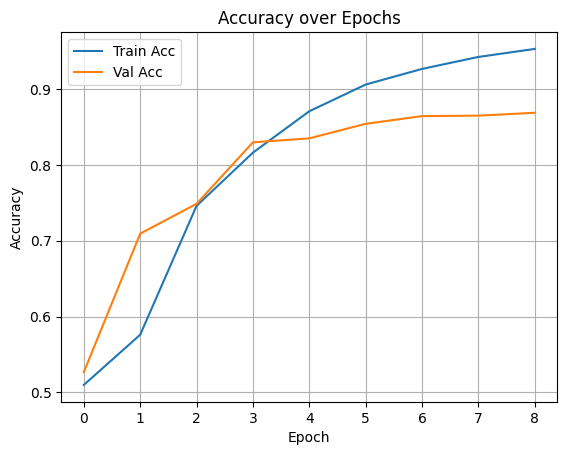

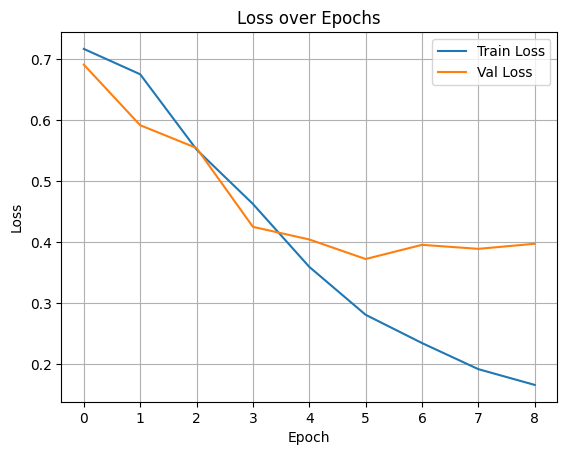

In [55]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### 8. Visualize How RNN Works

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


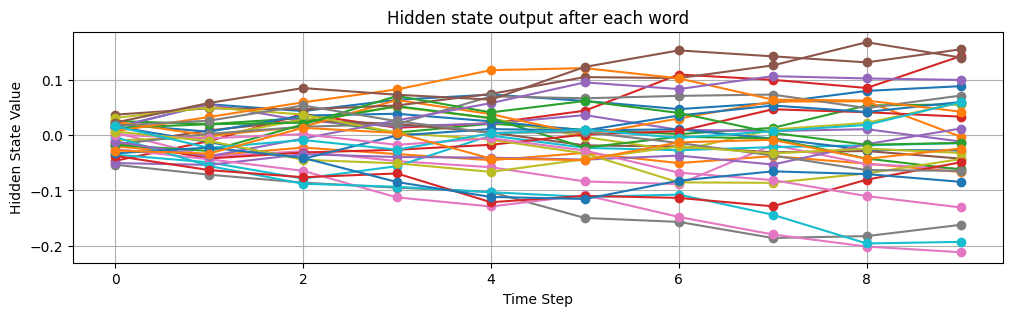

In [56]:
# Visualize how an RNN processes a short sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_rnn_steps(sequence, hidden_states):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(hidden_states, marker='o')
    ax.set_title("Hidden state output after each word")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Hidden State Value")
    ax.grid(True)
    plt.show()

# Select a short example
short_seq = x_test[0][:10].reshape(1, 10)

# Build a new model for this
rnn_step_model = Sequential([
    Embedding(input_dim=num_words, output_dim=32, input_length=10),
    SimpleRNN(32, return_sequences=True),  # We need the hidden states for each step
])
output = rnn_step_model.predict(short_seq)

plot_rnn_steps(short_seq.flatten(), output[0])


### Using LSTM to classify sentiment on IMDB data

#### 1. Load and Prepare data

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

num_words = 10000
maxlen = 200  # Limit review length to 200

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Pad sequences to the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 2. Build the LSTM model

In [35]:
from tensorflow.keras.layers import Bidirectional, Dropout
model_lstm = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 3. Train the model

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/10
157/157 - 11s - 70ms/step - accuracy: 0.7387 - loss: 0.5081 - val_accuracy: 0.8660 - val_loss: 0.3248
Epoch 2/10
157/157 - 10s - 63ms/step - accuracy: 0.9017 - loss: 0.2567 - val_accuracy: 0.8794 - val_loss: 0.3223
Epoch 3/10
157/157 - 10s - 67ms/step - accuracy: 0.9377 - loss: 0.1781 - val_accuracy: 0.8526 - val_loss: 0.3936
Epoch 4/10
157/157 - 10s - 63ms/step - accuracy: 0.9599 - loss: 0.1203 - val_accuracy: 0.8658 - val_loss: 0.4310
Epoch 5/10
157/157 - 10s - 63ms/step - accuracy: 0.9679 - loss: 0.0943 - val_accuracy: 0.8650 - val_loss: 0.5174


#### 4. Evaluate and Compare

In [37]:
test_loss, test_acc = model_lstm.evaluate(x_test, y_test)
print(f"LSTM Test Accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8695 - loss: 0.3382
LSTM Test Accuracy: 0.8696


#### 5. Visulize the training of LSTM

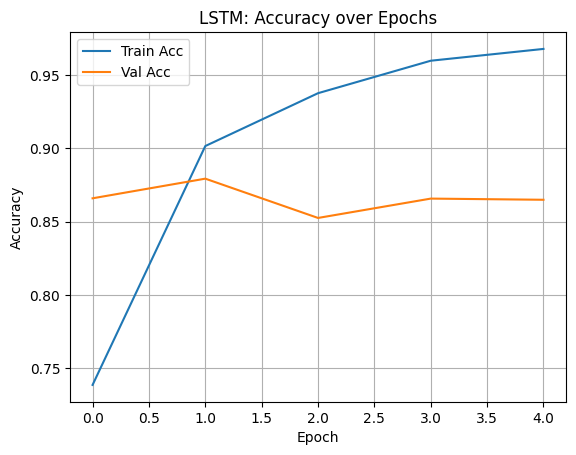

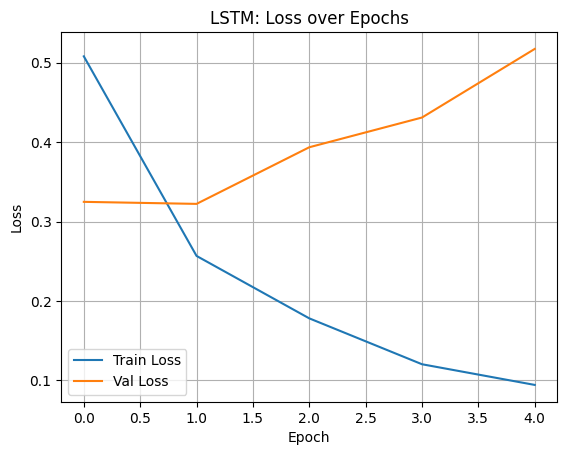

In [38]:
# Accuracy
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title('LSTM: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Using GRU to classify sentiment on IMDB data¶

#### 1. Load and Preprocess the IMDB Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 10000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

#### 2. Build GRU Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

model_gru = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),  # Increased embedding size
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=False, dropout=0.3)),  # Bidirectional GRU
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=1e-4)
model_gru.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


model_gru.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 3. Train the model

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model_gru.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/10
157/157 - 7s - 46ms/step - accuracy: 0.5148 - loss: 0.6927 - val_accuracy: 0.5484 - val_loss: 0.6914
Epoch 2/10
157/157 - 5s - 31ms/step - accuracy: 0.5607 - loss: 0.6882 - val_accuracy: 0.6082 - val_loss: 0.6819
Epoch 3/10
157/157 - 4s - 25ms/step - accuracy: 0.6778 - loss: 0.6184 - val_accuracy: 0.7958 - val_loss: 0.4572
Epoch 4/10
157/157 - 4s - 24ms/step - accuracy: 0.8365 - loss: 0.3824 - val_accuracy: 0.8492 - val_loss: 0.3431
Epoch 5/10
157/157 - 4s - 25ms/step - accuracy: 0.8775 - loss: 0.3023 - val_accuracy: 0.8716 - val_loss: 0.3190
Epoch 6/10
157/157 - 5s - 32ms/step - accuracy: 0.8997 - loss: 0.2561 - val_accuracy: 0.8664 - val_loss: 0.3124
Epoch 7/10
157/157 - 4s - 24ms/step - accuracy: 0.9143 - loss: 0.2287 - val_accuracy: 0.8690 - val_loss: 0.3100
Epoch 8/10
157/157 - 6s - 36ms/step - accuracy: 0.9200 - loss: 0.2122 - val_accuracy: 0.8742 - val_loss: 0.3198
Epoch 9/10
157/157 - 5s - 29ms/step - accuracy: 0.9322 - loss: 0.1865 - val_accuracy: 0.8722 - val_loss:

#### 4. Evaluate the GRU model

In [41]:
test_loss, test_acc = model_gru.evaluate(x_test, y_test)
print(f"GRU Test Accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8681 - loss: 0.3186
GRU Test Accuracy: 0.8680


#### 5. Visulize the training process

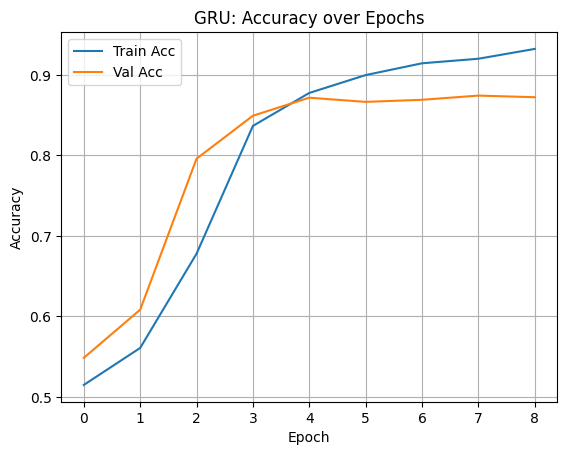

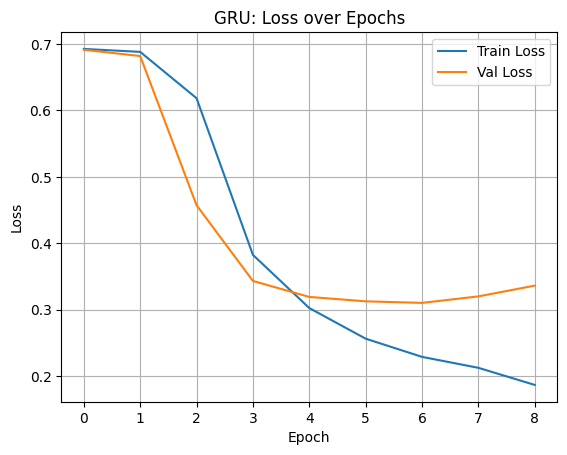

In [42]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('GRU: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('GRU: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Basic Comparision

In [ ]:
decode_review(x_test[100])

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> a quick glance at the premise of this film would seem to indicate just another dumb <UNK> <UNK> <UNK> slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread <UNK> tension amidst a lovely <UNK> backdrop these feelings are further <UNK> by a cast of realistically likable characters and <UNK> that are more amoral than cardboard <UNK> of evil oh yeah george kennedy is

In [61]:
# Predict sentiment on one review
sample = x_test[100].reshape(1, -1)

pred_rnn = model.predict(sample)[0][0]
pred_lstm = model_lstm.predict(sample)[0][0]
pred_gru = model_gru.predict(sample)[0][0]

print(f"RNN Prediction: {pred_rnn:.4f}")
print(f"LSTM Prediction: {pred_lstm:.4f}")
print(f"GRU Prediction: {pred_gru:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
RNN Prediction: 0.0647
LSTM Prediction: 0.0287
GRU Prediction: 0.0416


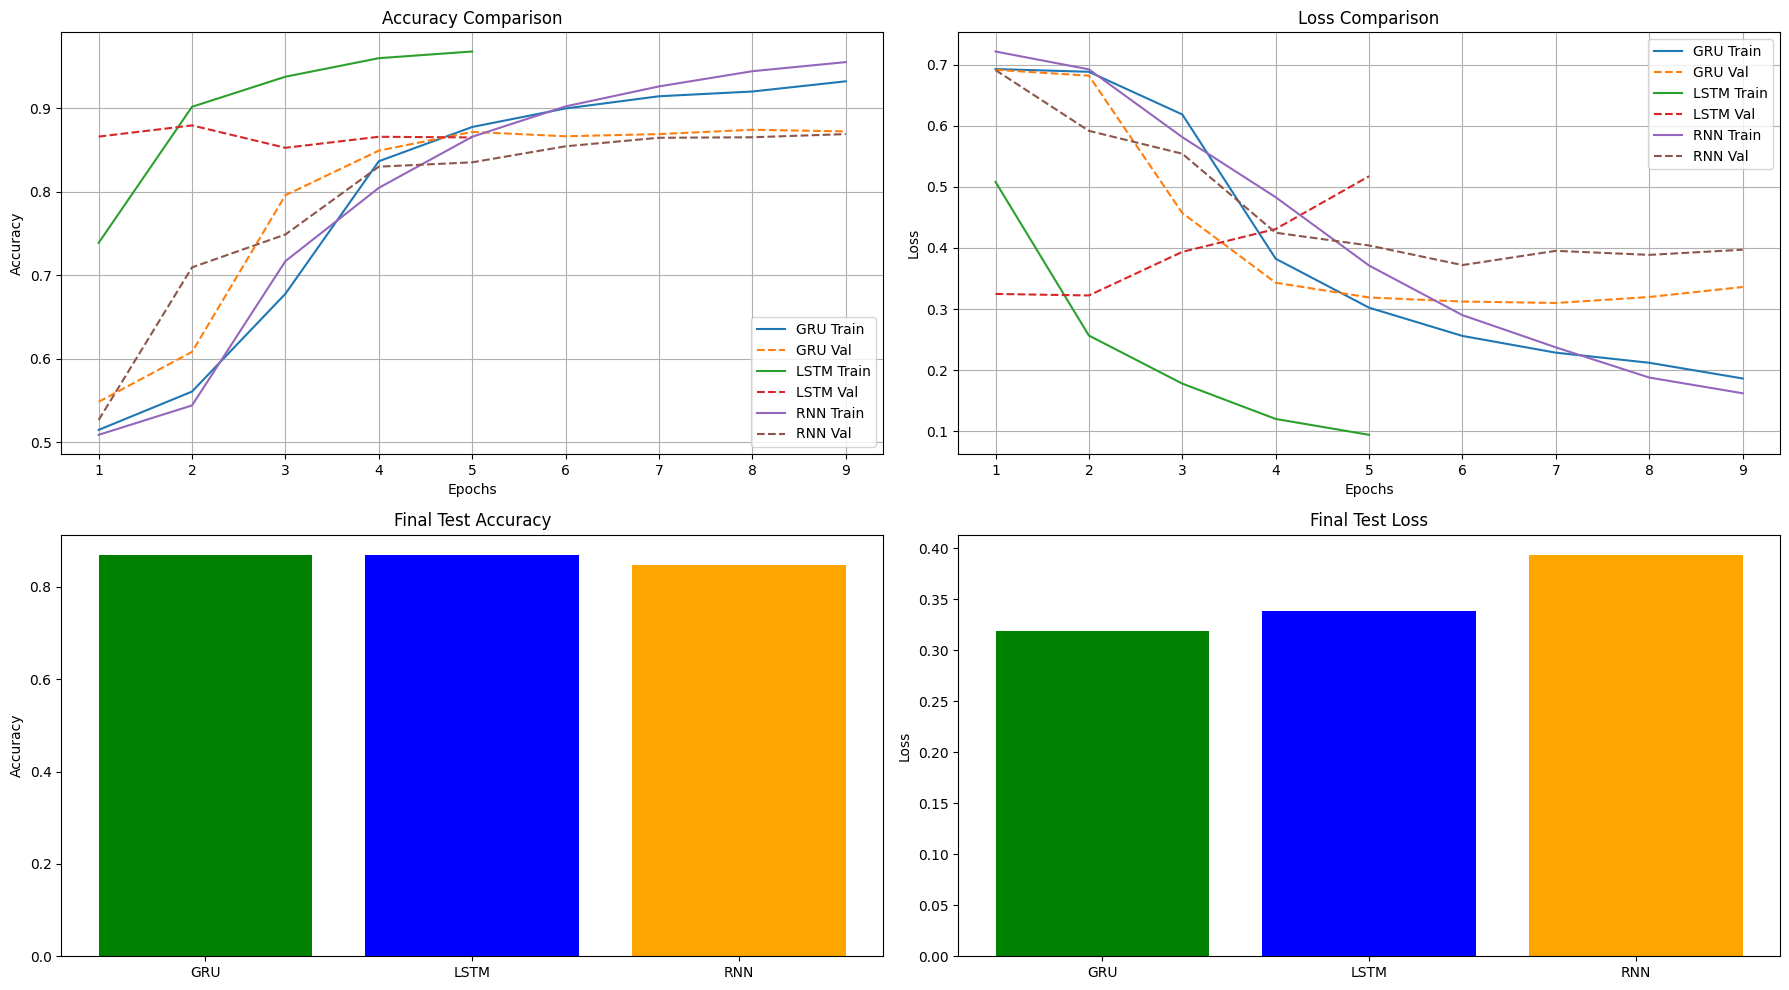

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = np.arange(1, 10)

# GRU Metrics
gru_acc = [0.5148, 0.5607, 0.6778, 0.8365, 0.8775, 0.8997, 0.9143, 0.9200, 0.9322]
gru_val_acc = [0.5484, 0.6082, 0.7958, 0.8492, 0.8716, 0.8664, 0.8690, 0.8742, 0.8722]
gru_loss = [0.6927, 0.6882, 0.6184, 0.3824, 0.3023, 0.2561, 0.2287, 0.2122, 0.1865]
gru_val_loss = [0.6914, 0.6819, 0.4572, 0.3431, 0.3190, 0.3124, 0.3100, 0.3198, 0.3361]

# LSTM Metrics
lstm_acc = [0.7387, 0.9017, 0.9377, 0.9599, 0.9679]
lstm_val_acc = [0.8660, 0.8794, 0.8526, 0.8658, 0.8650]
lstm_loss = [0.5081, 0.2567, 0.1781, 0.1203, 0.0943]
lstm_val_loss = [0.3248, 0.3223, 0.3936, 0.4310, 0.5174]

# RNN Metrics
rnn_acc = [0.5089, 0.5441, 0.7169, 0.8046, 0.8658, 0.9022, 0.9261, 0.9443, 0.9552]
rnn_val_acc = [0.5266, 0.7094, 0.7488, 0.8300, 0.8352, 0.8544, 0.8646, 0.8652, 0.8690]
rnn_loss = [0.7214, 0.6922, 0.5813, 0.4830, 0.3713, 0.2901, 0.2374, 0.1880, 0.1623]
rnn_val_loss = [0.6910, 0.5916, 0.5542, 0.4249, 0.4041, 0.3720, 0.3953, 0.3887, 0.3971]

# Plotting
plt.figure(figsize=(18, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs[:len(gru_acc)], gru_acc, label="GRU Train")
plt.plot(epochs[:len(gru_val_acc)], gru_val_acc, '--', label="GRU Val")
plt.plot(epochs[:len(lstm_acc)], lstm_acc, label="LSTM Train")
plt.plot(epochs[:len(lstm_val_acc)], lstm_val_acc, '--', label="LSTM Val")
plt.plot(epochs[:len(rnn_acc)], rnn_acc, label="RNN Train")
plt.plot(epochs[:len(rnn_val_acc)], rnn_val_acc, '--', label="RNN Val")
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs[:len(gru_loss)], gru_loss, label="GRU Train")
plt.plot(epochs[:len(gru_val_loss)], gru_val_loss, '--', label="GRU Val")
plt.plot(epochs[:len(lstm_loss)], lstm_loss, label="LSTM Train")
plt.plot(epochs[:len(lstm_val_loss)], lstm_val_loss, '--', label="LSTM Val")
plt.plot(epochs[:len(rnn_loss)], rnn_loss, label="RNN Train")
plt.plot(epochs[:len(rnn_val_loss)], rnn_val_loss, '--', label="RNN Val")
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Final Accuracy Bar Plot
plt.subplot(2, 2, 3)
final_test_acc = [0.8681, 0.8696, 0.8474]
models = ['GRU', 'LSTM', 'RNN']
plt.bar(models, final_test_acc, color=['green', 'blue', 'orange'])
plt.title("Final Test Accuracy")
plt.ylabel("Accuracy")

# Final Loss Bar Plot
plt.subplot(2, 2, 4)
final_test_loss = [0.3186, 0.3382, 0.3938]
plt.bar(models, final_test_loss, color=['green', 'blue', 'orange'])
plt.title("Final Test Loss")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


# Sequence Model Comparison Report (IMDB Sentiment Classification)

##  Models Compared
- **Model 1:** Bidirectional Simple RNN
- **Model 2:** Bidirectional LSTM
- **Model 3:** Bidirectional GRU

---

##  Model Architectures Explained

###  1. Bidirectional Simple RNN

```python
model = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=maxlen),
    Bidirectional(SimpleRNN(64, return_sequences=True)),  
    Dropout(0.4),
    SimpleRNN(32),  
    Dropout(0.4),
    Dense(32, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])
````

####  Architectural Characteristics:

* **Vanilla RNN units** (suffer from vanishing gradient).
* **Two stacked RNNs**: First bidirectional with `return_sequences`, second unidirectional.
* **Shallow embedding (64-dim)**.
* **High dropout** to reduce overfitting.
* Good for short context tasks, not very deep memory.

---

### 2. Bidirectional LSTM

```python
model_lstm = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
```

####  Architectural Characteristics:

* **LSTM units** (handle long-term dependencies via gates).
* **Two Bidirectional layers** with decreasing size (64 → 32).
* **Deep stacked memory layers**.
* **Heavier dropout** to fight overfitting.
* **Better for capturing complex sentence structure**.

---

###  3. Bidirectional GRU

```python
model_gru = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=False, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])
```

####  Architectural Characteristics:

* **GRU units** (simplified LSTM, fewer gates, faster).
* **Single Bidirectional GRU layer**, no stacking.
* **Larger embedding size (128-dim)**.
* **Efficient memory usage**, good generalization.
* Balances performance and speed; less prone to overfitting than LSTM.

---

##  Performance Summary

| Metric           | Bidirectional RNN | Bidirectional LSTM | Bidirectional GRU |
| ---------------- | ----------------- | ------------------ | ----------------- |
| Train Accuracy   | 95.5%             | 96.7%              | 93.2%             |
| Val Accuracy     | 86.9%             | 87.9%              | 87.4%             |
| Test Accuracy    | 84.7%             | 86.96%             | 86.8%             |
| Train Loss       | 0.1623            | 0.0943             | 0.1865            |
| Val Loss         | 0.3971            | 0.5174             | 0.3361            |
| Test Loss        | 0.3938            | 0.3382             | 0.3186            |
| Training Speed   |  Fast            |  Slow            |  Moderate        |
| Overfitting Risk |  Medium         |  High             |  Balanced        |


